# Explore Fish Counts

Loads `data/2025-11-19_discount_f_g.json` (true count **f**, detector count **g**, and **clip** id with date) and produces exploratory plots.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Load data

In [2]:
with open("../data/2025-11-19_discount_f_g.json") as fp:
    raw = json.load(fp)

df = pd.DataFrame({
    "true": np.array(raw["f"], dtype=np.int32),
    "detector": np.array(raw["g"], dtype=np.float64),
    "clip": raw["clip"],
})
# Extract date from clip (e.g. "2024-10-22_020000" -> "2024-10-22")
df["date"] = df["clip"].str.split("_").str[0]
df["detector_bin"] = df["detector"].round().astype(int).clip(0, None)

print(f"Loaded {len(df)} observations")
print(f"True count:    min={df['true'].min()}, max={df['true'].max()}, mean={df['true'].mean():.2f}")
print(f"Detector:     min={df['detector'].min()}, max={df['detector'].max()}, mean={df['detector'].mean():.2f}")
print(f"Dates: {df['date'].nunique()} unique ({df['date'].min()} to {df['date'].max()})")
df.head(10)

Loaded 658 observations
True count:    min=0, max=36, mean=9.14
Detector:     min=0.0, max=34.0, mean=7.44
Dates: 15 unique (2024-10-17 to 2024-10-31)


,true,detector,clip,date,detector_bin
0,10,9.0,2024-10-22_020000,2024-10-22,9
1,12,9.0,2024-10-22_120000,2024-10-22,9
2,19,15.0,2024-10-21_083000,2024-10-21,15
3,3,2.0,2024-10-21_183000,2024-10-21,2
4,5,4.0,2024-10-20_213000,2024-10-20,4
5,5,4.0,2024-10-17_213000,2024-10-17,4
6,7,9.0,2024-10-22_043000,2024-10-22,9
7,6,4.0,2024-10-19_220000,2024-10-19,4
8,18,14.0,2024-10-22_143000,2024-10-22,14
9,6,4.0,2024-10-25_203000,2024-10-25,4


## 1. Heatmap: detector count (x) vs true count (y), columns normalized

For each detector count (column), the distribution of true counts is normalized so columns sum to 1.

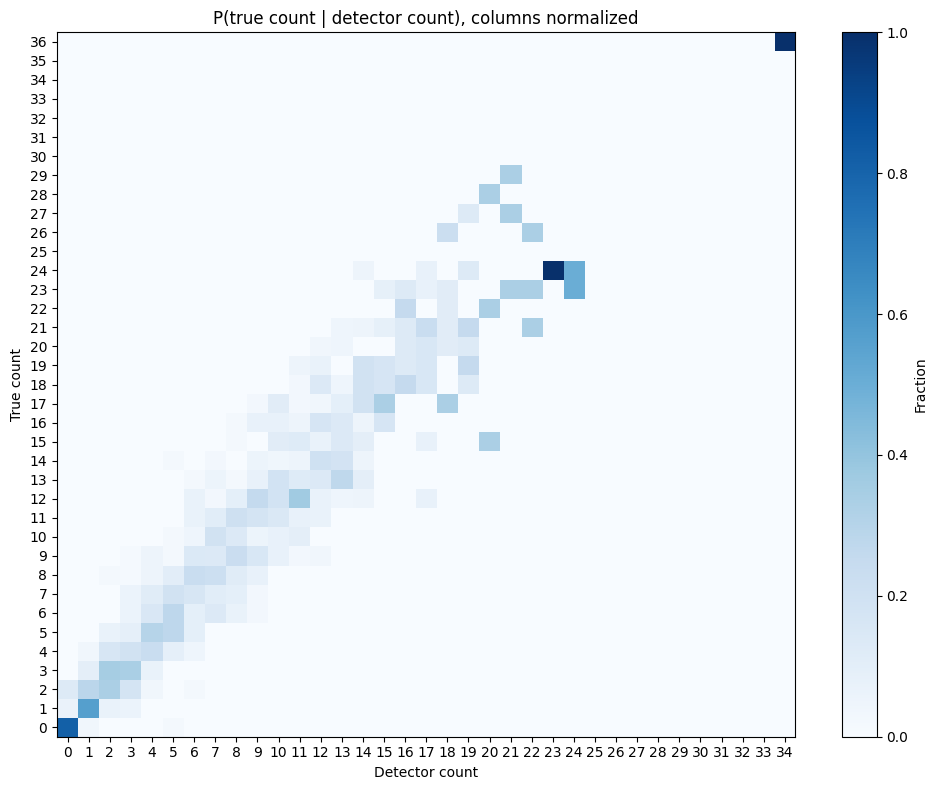

In [9]:
ct = pd.crosstab(df["true"], df["detector_bin"], normalize="columns")
# Align so all detector values in range appear
g_min, g_max = int(df["detector"].min()), int(df["detector"].max())
cols = np.arange(g_min, g_max + 1)
ct = ct.reindex(columns=cols).fillna(0)
ct = ct.reindex(index=np.arange(0, df["true"].max() + 1)).fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(ct.values, aspect="auto", origin="lower", cmap="Blues", vmin=0, vmax=1)
ax.set_xticks(np.arange(len(ct.columns)))
ax.set_xticklabels(ct.columns.astype(int))
ax.set_yticks(np.arange(ct.index.size))
ax.set_yticklabels(ct.index.astype(int))
ax.set_xlabel("Detector count")
ax.set_ylabel("True count")
ax.set_title("P(true count | detector count), columns normalized")
plt.colorbar(im, ax=ax, label="Fraction")
plt.tight_layout()
plt.show()

## 2. Variance of true counts vs detector count (with y=x line)

For each detector count value, compute the variance of the corresponding true counts; then plot variance vs detector count. The y=x line is the Poisson expectation (variance = mean).

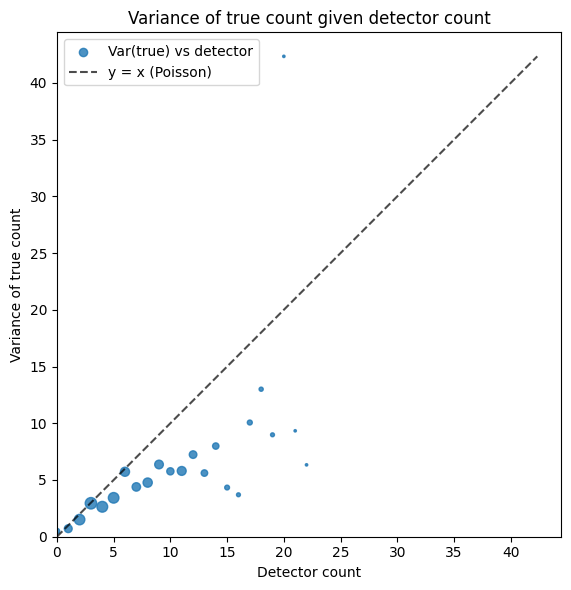

In [10]:
by_g = df.groupby("detector_bin")["true"].agg(["mean", "var", "count"]).reset_index()
by_g = by_g[by_g["count"] >= 3]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(by_g["detector_bin"], by_g["var"], s=by_g["count"].clip(1, 80), alpha=0.8, label="Var(true) vs detector")
lim = max(by_g["detector_bin"].max(), by_g["var"].max(), 1)
ax.plot([0, lim], [0, lim], "k--", alpha=0.7, label="y = x (Poisson)")
ax.set_xlabel("Detector count")
ax.set_ylabel("Variance of true count")
ax.set_title("Variance of true count given detector count")
ax.legend()
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

(Variance plot uses `detector_bin` from rounded detector count; points sized by sample count.)

## 3. Other informative plots

Marginal distributions, scatter of true vs detector, and mean true vs detector.

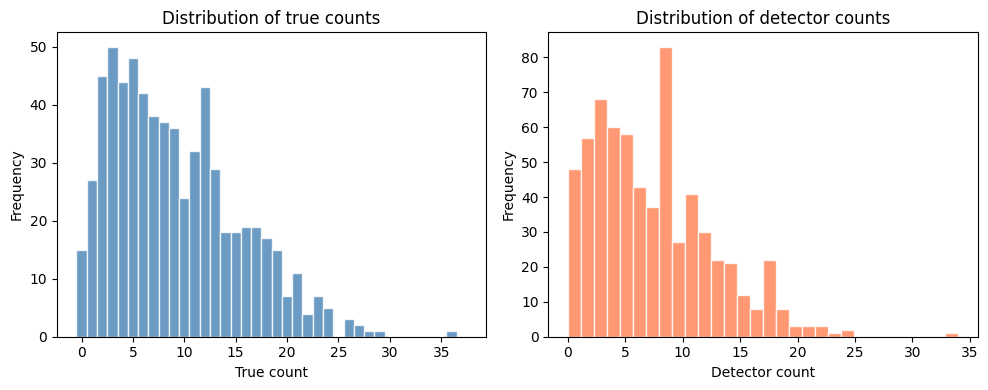

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df["true"], bins=np.arange(-0.5, df["true"].max() + 2), alpha=0.8, color="steelblue", edgecolor="white")
axes[0].set_xlabel("True count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of true counts")

axes[1].hist(df["detector"], bins=30, alpha=0.8, color="coral", edgecolor="white")
axes[1].set_xlabel("Detector count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of detector counts")
plt.tight_layout()
plt.show()

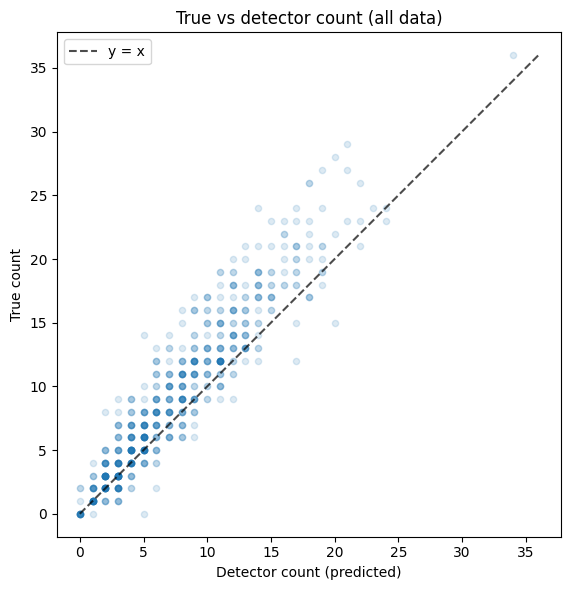

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df["detector"], df["true"], alpha=0.15, s=20)
ax.plot([0, df[["true", "detector"]].max().max()], [0, df[["true", "detector"]].max().max()], "k--", alpha=0.7, label="y = x")
ax.set_xlabel("Detector count (predicted)")
ax.set_ylabel("True count")
ax.set_title("True vs detector count (all data)")
ax.legend()
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

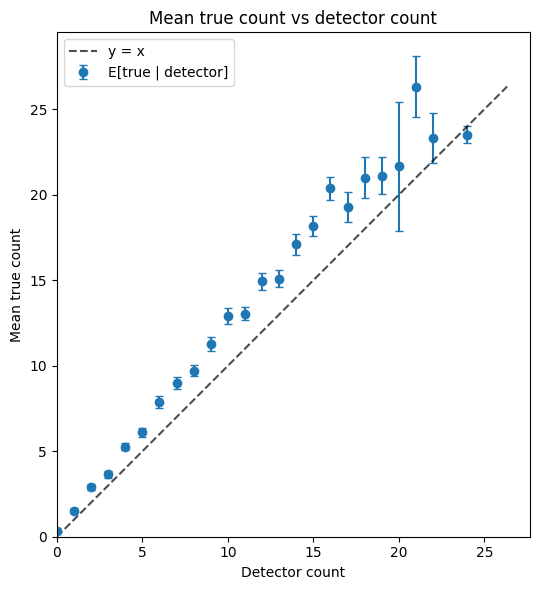

In [13]:
by_g = df.groupby("detector_bin")["true"].agg(["mean", "std", "count"]).reset_index()
by_g = by_g[by_g["count"] >= 2]

fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(
    by_g["detector_bin"], by_g["mean"], yerr=by_g["std"] / np.sqrt(by_g["count"]),
    fmt="o", capsize=3, label="E[true | detector]"
)
lim = max(by_g["detector_bin"].max(), by_g["mean"].max(), 1)
ax.plot([0, lim], [0, lim], "k--", alpha=0.7, label="y = x")
ax.set_xlabel("Detector count")
ax.set_ylabel("Mean true count")
ax.set_title("Mean true count vs detector count")
ax.legend()
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 4. True (y) vs predicted/detector (x) by date

One subplot per date; points with alpha=0.1 to show density.

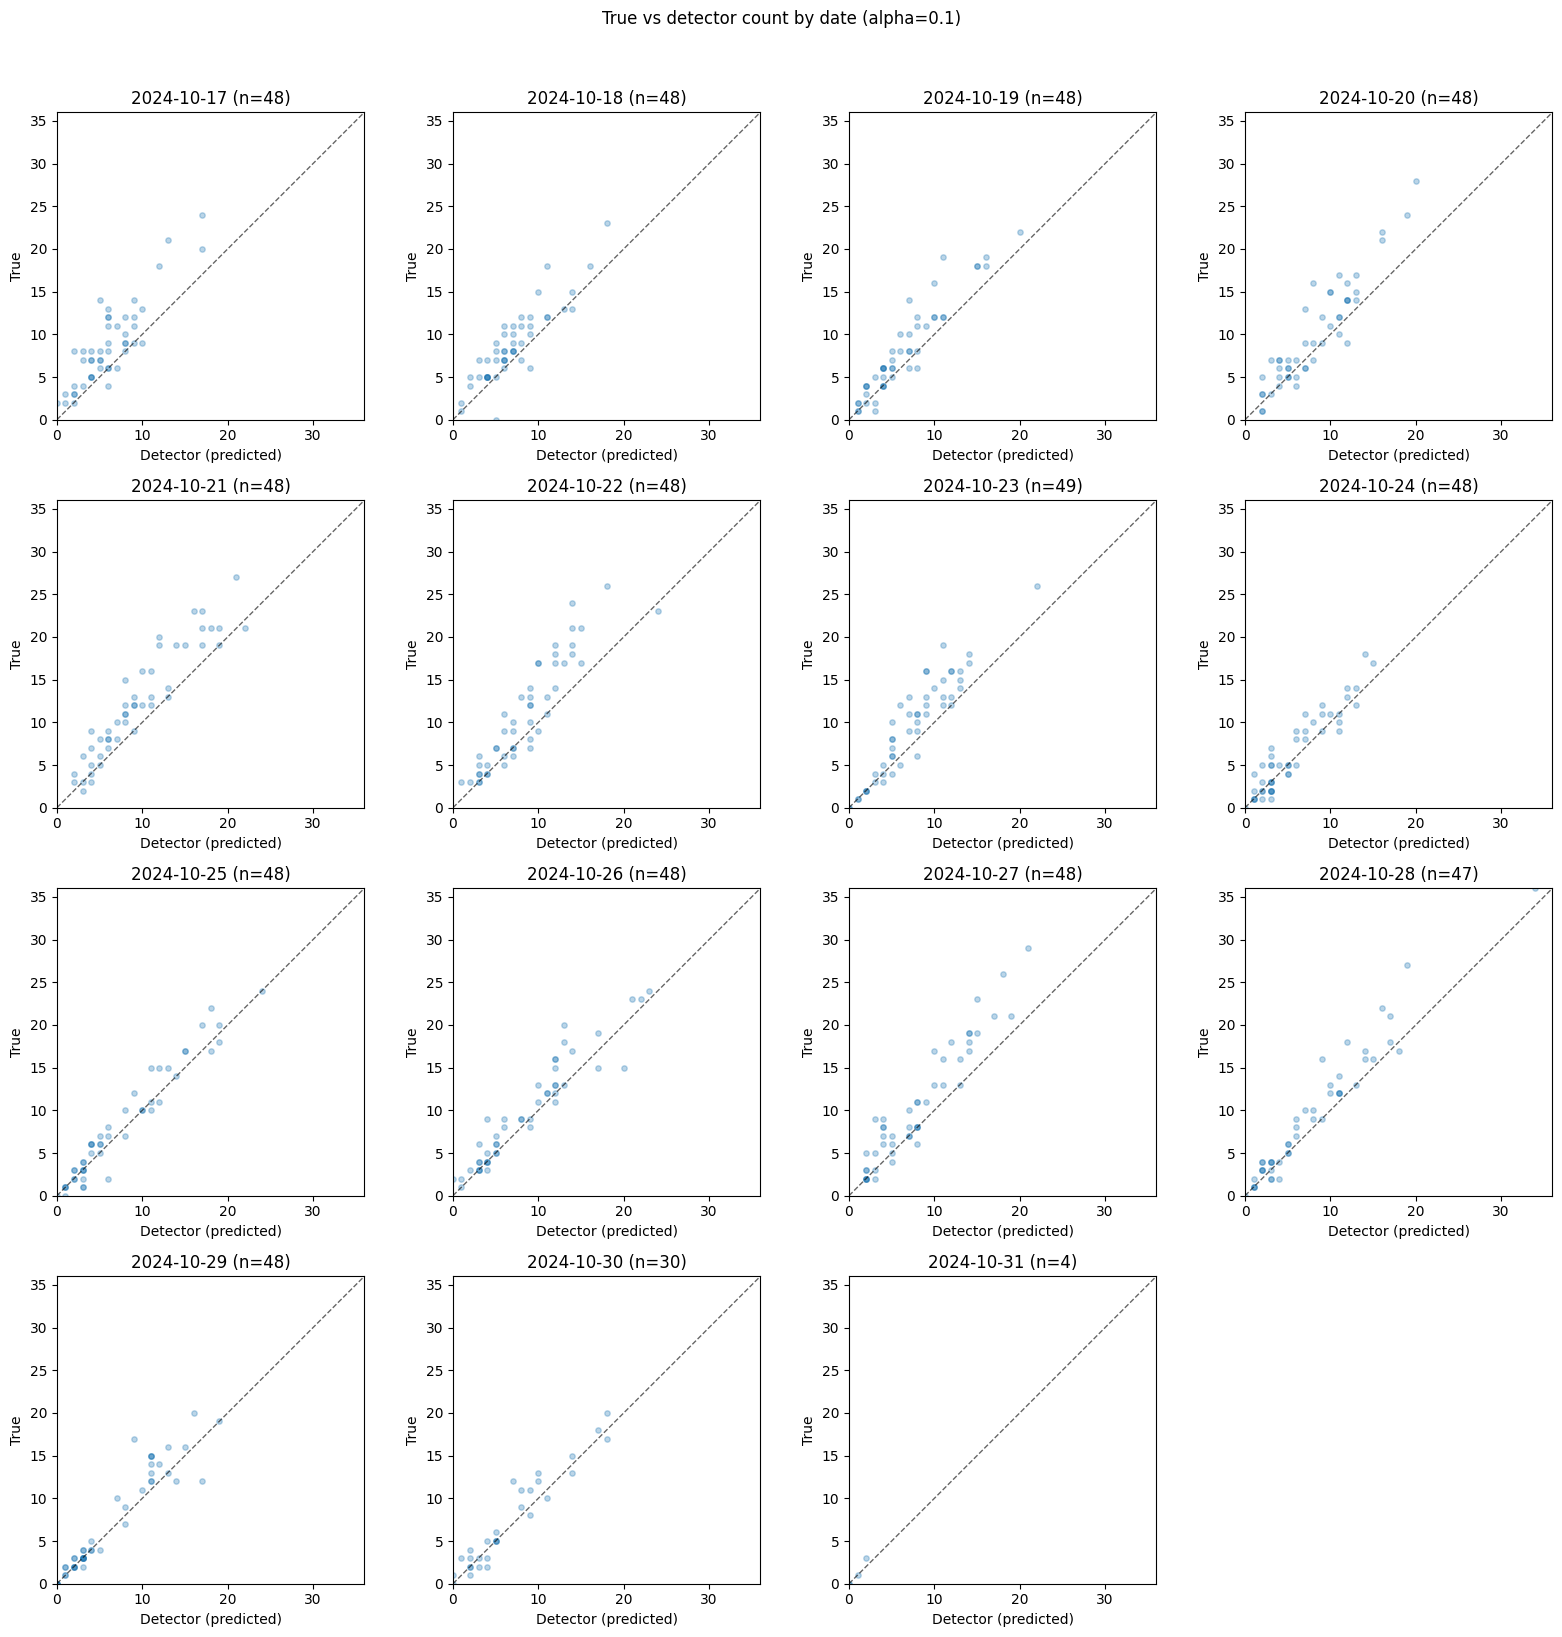

In [18]:
dates = sorted(df["date"].unique())
n_dates = len(dates)
n_cols = 4
n_rows = int(np.ceil(n_dates / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes)
lim = max(df["true"].max(), df["detector"].max())

for i, date in enumerate(dates):
    r, c = i // n_cols, i % n_cols
    ax = axes[r, c]
    sub = df[df["date"] == date]
    n_points = len(sub)
    ax.scatter(sub["detector"], sub["true"], alpha=0.3, s=15)
    ax.plot([0, lim], [0, lim], "k--", alpha=0.6, lw=1)
    ax.set_xlabel("Detector (predicted)")
    ax.set_ylabel("True")
    ax.set_title(f"{date} (n={n_points})")
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_aspect("equal")

for j in range(i + 1, axes.size):
    r, c = j // n_cols, j % n_cols
    axes[r, c].set_visible(False)

plt.suptitle("True vs detector count by date (alpha=0.1)", y=1.02)
plt.tight_layout()
plt.show()